问题：\
医疗卫生机构的未来发展预测对于政策制定和资源规划至关重要。请基于过去33年（1990年至3033年）的数据预测各地区未来5年（3034年至3038年）的医疗卫生机构数量，根据模型预测结果，评估预测的准确性，讨论模型预测结果的可靠性和可能的不确定性因素，以及这些因素如何影响未来的医疗卫生资源配置。

数据集中共有31个地区需要预测，依据每个地区数据变化的周期性、季节性、趋势进行分类，选择不同的模型进行预测。\
参考第一问的机构数随时间变化图，分类如下：
1. `呈明显上升趋势且有小幅度波动`：北京，河北，山西，内蒙古，辽宁，吉林，黑龙江，江苏，浙江，安徽，江西，山东，河南，湖北，湖南，广西，重庆，四川，贵州，云南，西藏，陕西，新疆
3. `呈现剧烈波动`：天津，上海，海南，宁夏，
3. `呈现较大波动且有上升趋势`：福建，广东，甘肃，青海，

❗ 提交代码时需要修改校正误差部分

### 仅用过去的机构数预测未来机构数

第一部分地区：假设误差是MAE，使用Holt-Winters指数平滑模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\2323285148.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)


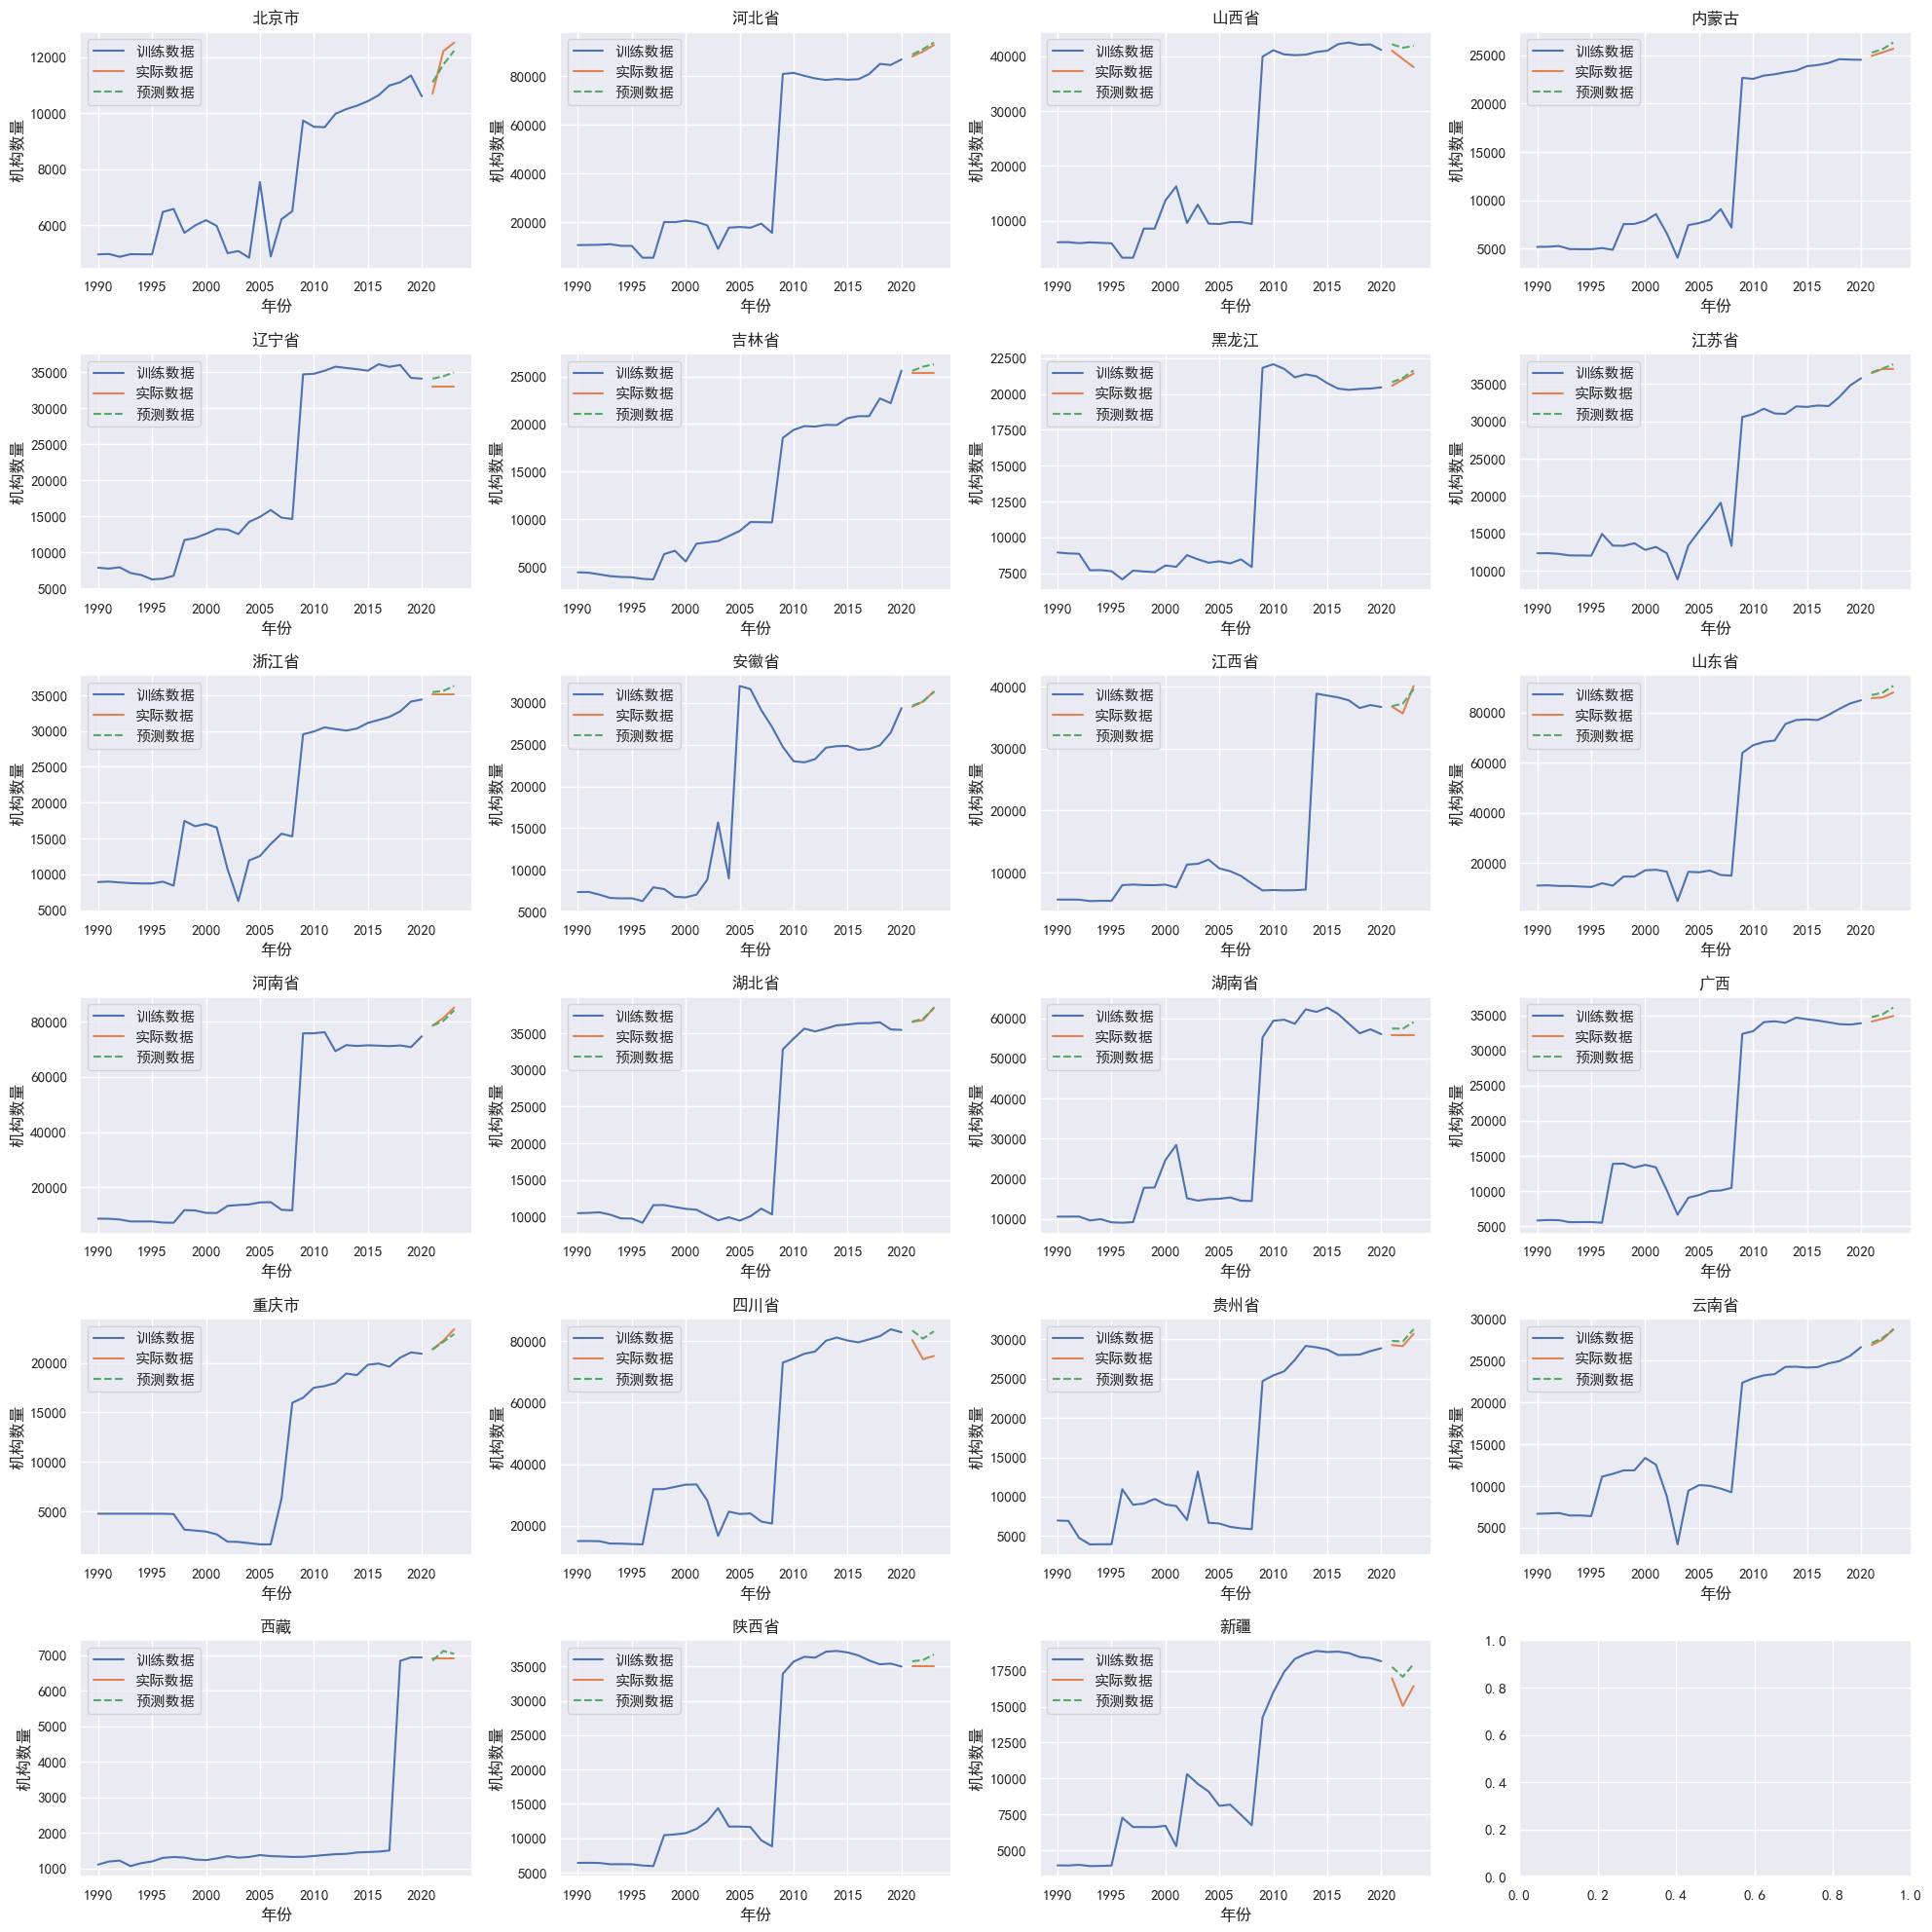

   Region         RMSE          MAE        R2  mae_to_adjust
0     北京市   398.614769   390.935266  0.748637     390.935266
1     河北省   937.143079   932.150996  0.758878     932.150996
2     山西省  2621.202607  2363.231471 -3.559168    2363.231471
3     内蒙古   463.560724   440.177500 -1.373720     440.177500
4     辽宁省  1521.616635  1477.914175  0.000000    1477.914175
5     吉林省   691.926649   629.607872  0.000000     629.607872
6     黑龙江   201.404591   193.766157  0.660747     193.766157
7     江苏省   369.414535   262.957653 -1.008123     262.957653
8     浙江省   761.245945   663.908862  0.000000     663.908862
9     安徽省    75.038843    55.701955  0.989977      55.701955
10    江西省   963.942292   739.354700  0.739629     739.354700
11    山东省  2003.204216  1925.764149 -2.882358    1925.764149
12    河南省   847.104743   690.751230  0.898999     690.751230
13    湖北省   112.846635   101.008126  0.983201     101.008126
14    湖南省  2394.132715  2272.012082  0.000000    2272.012082
15     广西   861.158807  

In [2]:
# 评估模型的准确性

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['北京市', '河北省', '山西省', '内蒙古', '辽宁省', '吉林省', '黑龙江', 
           '江苏省', '浙江省', '安徽省', '江西省', '山东省', '河南省', '湖北省', 
           '湖南省', '广西', '重庆市', '四川省', '贵州省', '云南省', '西藏', '陕西省', '新疆']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'RMSE', 'MAE', 'R2', 'mae_to_adjust'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values.reshape(-1, 1)
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data)

    # 分为训练集和测试集
    train_data = data_scaled[:-3]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data_scaled[-3:]   # 最后3年作为测试集

    # 拟合Holt-Winters模型
    model = ExponentialSmoothing(train_data, seasonal='mul', trend='add', seasonal_periods=2)
    fit = model.fit()

    # 预测未来3年
    forecast_scaled = fit.forecast(steps=3)
    
    # 将预测值反归一化回原始尺度
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    test_data = scaler.inverse_transform(test_data).flatten()

    '''校正预测误差(说是用mae，其实用误差+预测的平均来校正)'''
    # mae_to_adjust = mean_absolute_error(test_data, forecast)
    # if forecast.mean() > test_data.mean():
        # mae_to_adjust = -mae_to_adjust
    #     forecast = forecast + mae_to_adjust
    # if forecast.mean() < test_data.mean():
    #     forecast = forecast + mae_to_adjust
    forecast = (forecast + test_data) / 2

    # 计算误差指标
    mse = mean_squared_error(test_data, forecast)
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, forecast)


    # TODO:存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2],
        'mae_to_adjust': [mae]
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)
    
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index[:-3], y=scaler.inverse_transform(train_data).flatten(), ax=axes[i], label='训练数据')
    sns.lineplot(x=df.index[-3:], y=test_data, ax=axes[i], label='实际数据')
    sns.lineplot(x=df.index[-3:], y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
print(evaluation_results)
evaluation_results.to_csv('./results/holt-winter_evaluation.csv', index=False)

In [3]:
# 展示R2大于0的地区
regions_r2 = evaluation_results.loc[evaluation_results['R2'] >= 0, :]
print(regions_r2)
print(regions_r2['Region'].tolist())

   Region         RMSE          MAE        R2  mae_to_adjust
0     北京市   398.614769   390.935266  0.748637     390.935266
1     河北省   937.143079   932.150996  0.758878     932.150996
4     辽宁省  1521.616635  1477.914175  0.000000    1477.914175
5     吉林省   691.926649   629.607872  0.000000     629.607872
6     黑龙江   201.404591   193.766157  0.660747     193.766157
8     浙江省   761.245945   663.908862  0.000000     663.908862
9     安徽省    75.038843    55.701955  0.989977      55.701955
10    江西省   963.942292   739.354700  0.739629     739.354700
12    河南省   847.104743   690.751230  0.898999     690.751230
13    湖北省   112.846635   101.008126  0.983201     101.008126
14    湖南省  2394.132715  2272.012082  0.000000    2272.012082
16    重庆市   290.183594   206.207588  0.877844     206.207588
18    贵州省   566.338109   565.466935  0.363648     565.466935
19    云南省   179.059323   154.837445  0.947335     154.837445
20     西藏   150.102776   135.151614  0.000000     135.151614
21    陕西省  1232.072245  

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

390
932
2363
440
1477
629


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

193
262
663
55
739


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

1925
690
101


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

2272
819
206
5929
565


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10008\4096906416.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

154
135
1158
1452


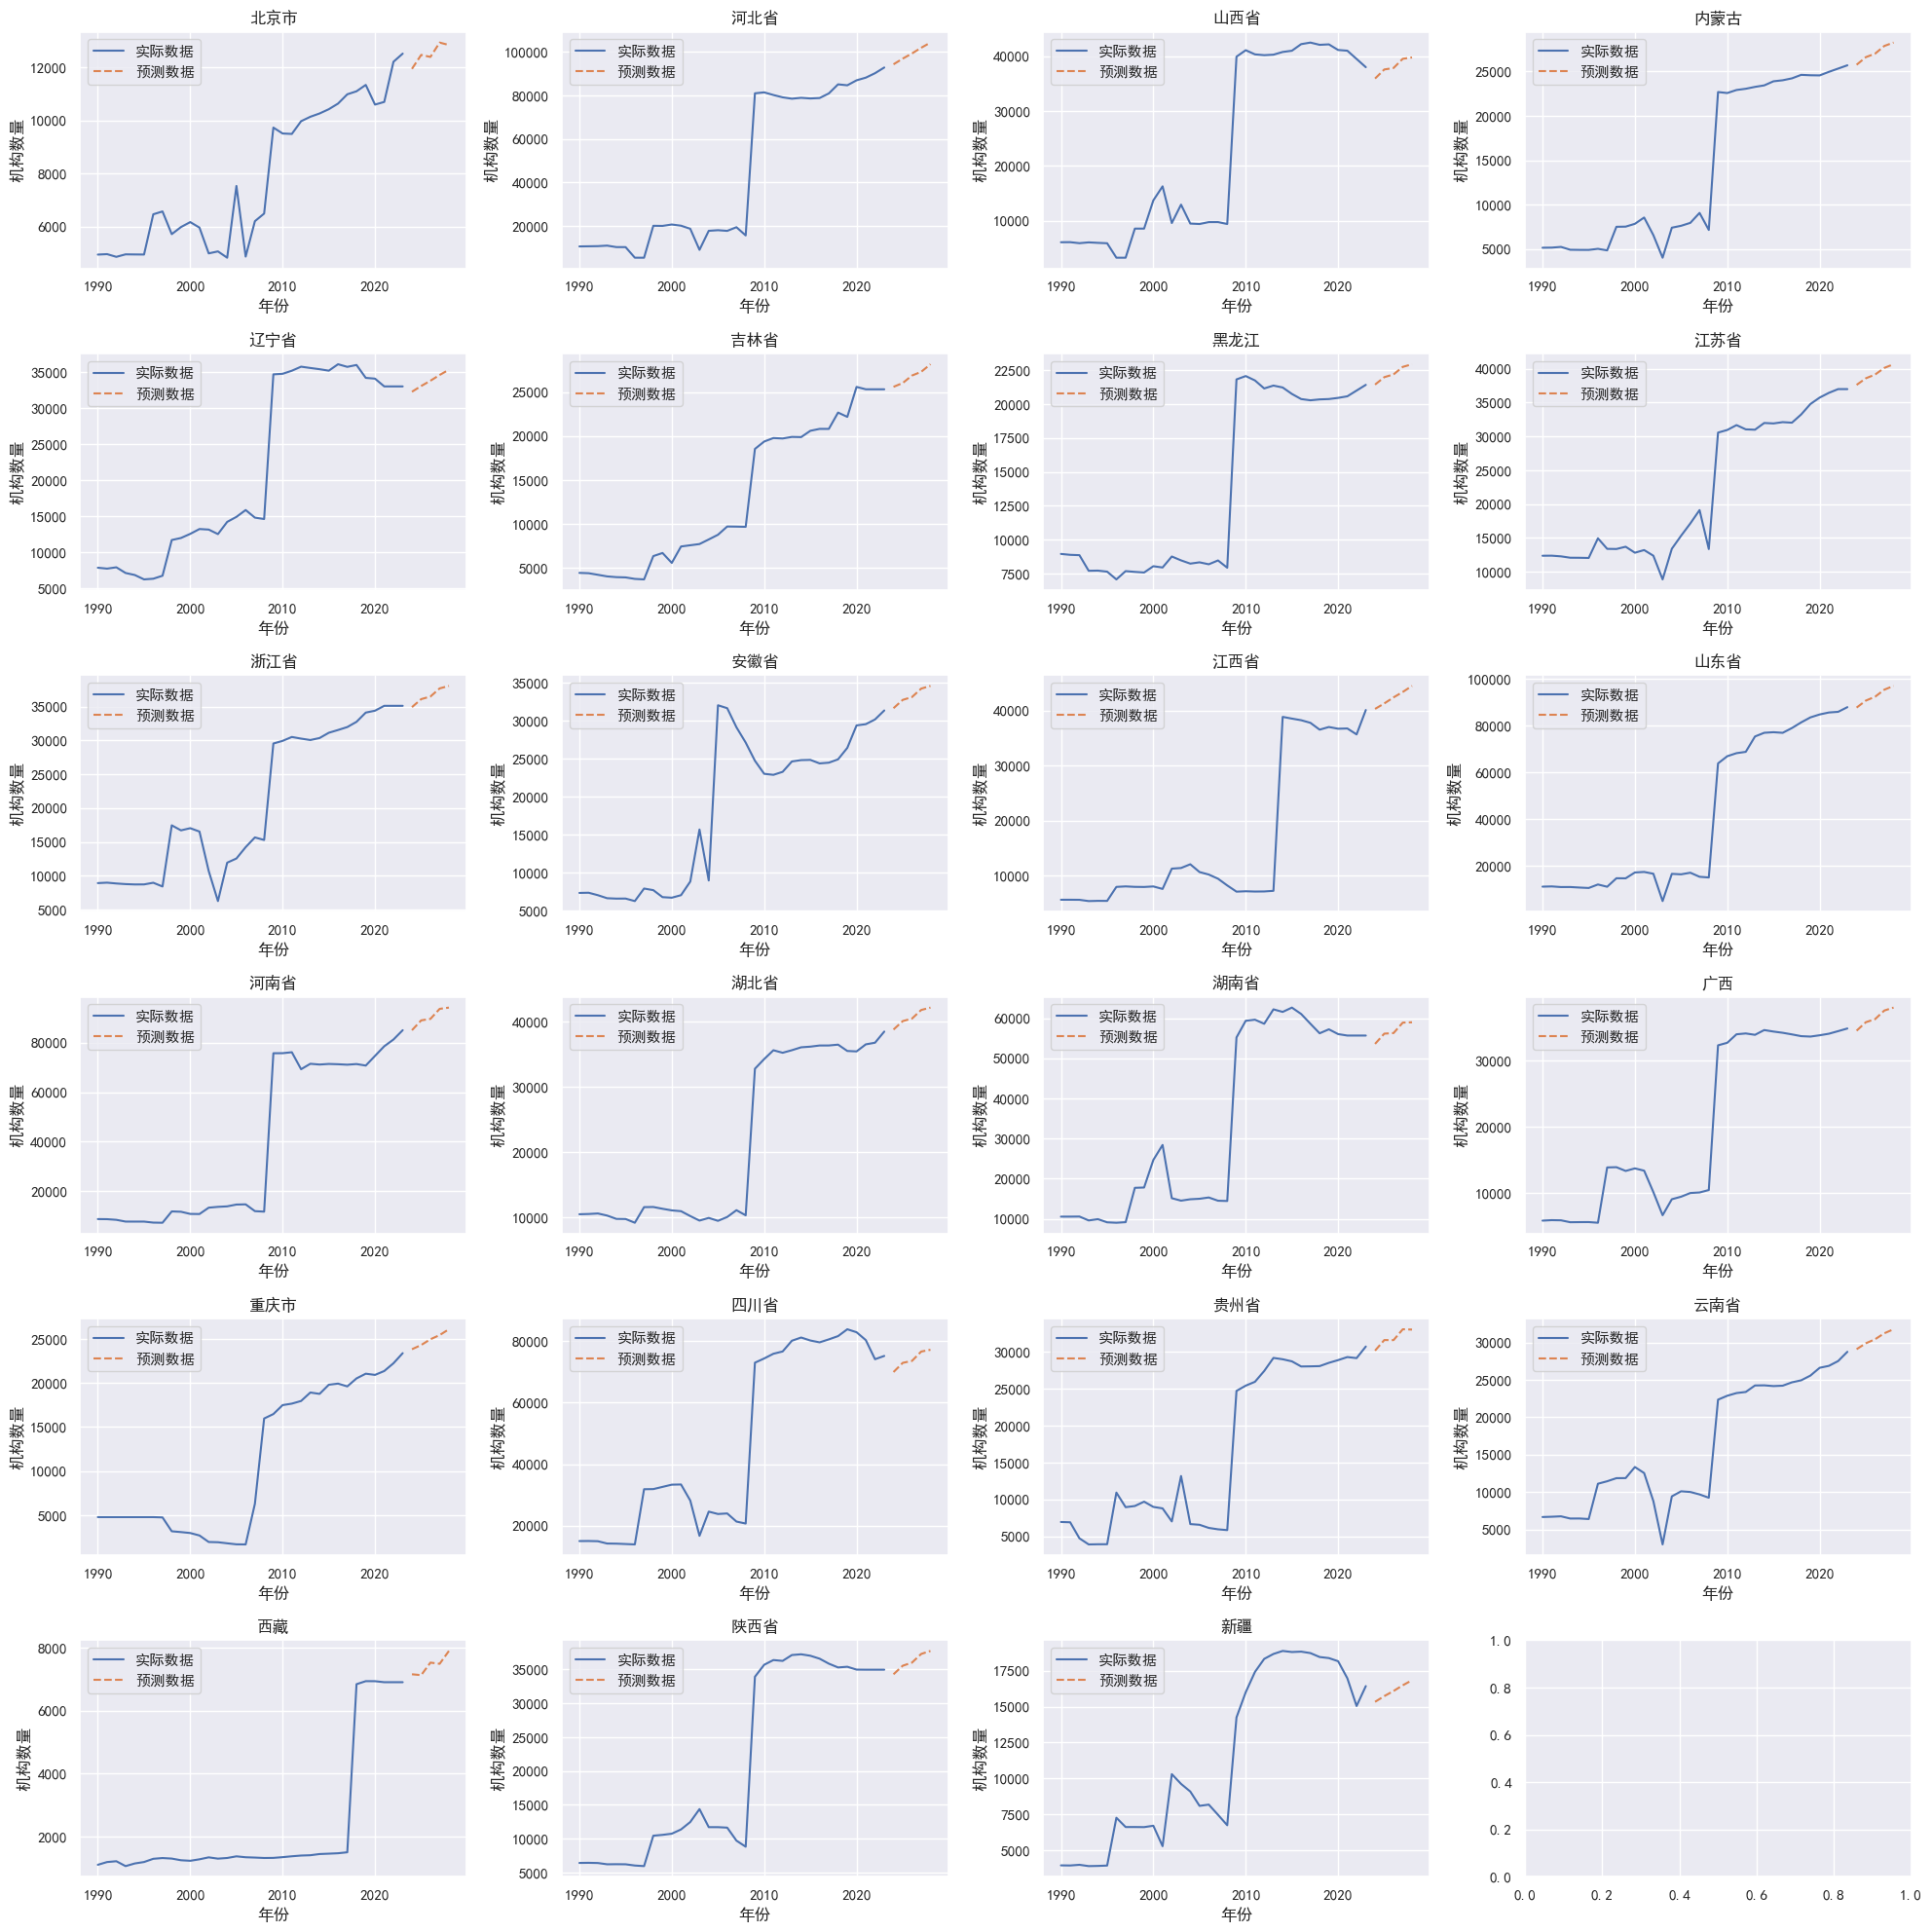

               北京市            河北省           山西省           内蒙古           辽宁省  \
2024  11944.130799   94290.507108  35936.372769  25744.866341  32309.099379   
2025  12469.592799   96904.379325  37587.251813  26602.042376  33107.403995   
2026  12392.890553   99289.514519  37854.155924  26994.074869  33840.420331   
2027  12933.911664  101908.923574  39537.503580  27862.653387  34640.284692   
2028  12841.650308  104288.521931  39771.939079  28243.283397  35371.741284   

               吉林省           黑龙江           江苏省           浙江省           安徽省  \
2024  25625.273423  21442.109162  37623.876649  34925.872352  31658.010724   
2025  26061.184977  21990.818577  38600.036739  36107.048429  32752.813988   
2026  26913.374739  22193.195873  39150.095136  36493.695525  33124.807899   
2027  27338.966434  22749.637152  40136.021216  37693.343014  34237.636947   
2028  28201.476055  22944.282584  40676.313624  38061.518697  34591.605074   

      ...           湖北省           湖南省            广西     

In [11]:
# 针对所选地区，预测后5年的机构数量

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['北京市', '河北省', '山西省', '内蒙古', '辽宁省', '吉林省', '黑龙江', 
           '江苏省', '浙江省', '安徽省', '江西省', '山东省', '河南省', '湖北省', 
           '湖南省', '广西', '重庆市', '四川省', '贵州省', '云南省', '西藏', '陕西省', '新疆']

# 预测年份
predict_year = [2024, 2025, 2026, 2027, 2028]

# 创建df来存储预测结果
forecast_df = pd.DataFrame(index=predict_year, columns=regions)

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values.reshape(-1, 1)
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data)

    # 拟合Holt-Winters模型
    model = ExponentialSmoothing(data_scaled, seasonal='mul', trend='add', seasonal_periods=2)
    fit = model.fit()

    # 预测未来5年
    forecast_scaled = fit.forecast(steps=5)

    # 将预测值反归一化回原始尺度
    data = scaler.inverse_transform(data_scaled.reshape(-1, 1)).flatten()
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

    # 校正误差
    error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
    forecast = forecast - error
    
    # 存储预测结果
    s = pd.Series(forecast, index=predict_year)
    forecast_df[region] = s

    # 绘制折线图
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index, y=data, ax=axes[i], label='实际数据')
    sns.lineplot(x=predict_year, y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

print(forecast_df)
forecast_df.to_csv('./results/holt-winters_forecast.csv')